In [2]:
!cp -r ./drive/MyDrive/ml_assignment2/cnn_dataset /content/dataset
dataset_path = './dataset'

Analysing and Visualising the dataset

0: 2800 images
1: 2800 images
2: 2800 images
3: 2800 images
4: 2800 images
5: 2800 images
6: 2800 images
7: 2800 images
8: 2800 images
9: 2800 images
A: 2800 images
B: 2800 images
C: 2800 images
D: 2800 images
E: 2800 images
F: 2800 images
G: 2800 images
H: 2800 images
I: 2800 images
J: 2800 images
K: 2800 images
L: 2800 images
M: 2800 images
N: 2800 images
O: 2800 images
P: 2800 images
Q: 2800 images
R: 2800 images
S: 2800 images
T: 2800 images
U: 2800 images
V: 2800 images
W: 2800 images
X: 2800 images
Y: 2800 images
Z: 2800 images
Total number of labels is: 36
Total number of images is: 100800


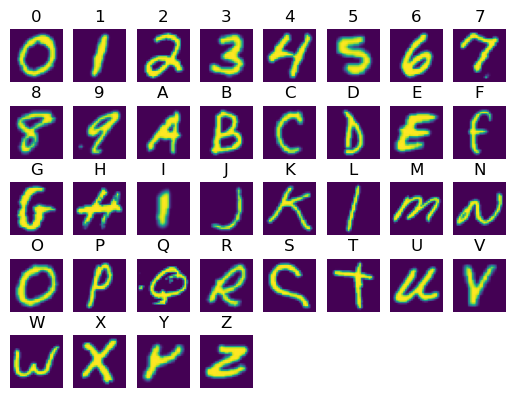

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dataset_path = './dataset'
label_names=os.listdir(dataset_path)
label_names=sorted(label_names)
total_valid_labels,total_num_of_images = 0,0
subplot_index=1
for label_name in label_names:
    image_folder_path = os.path.join(dataset_path, label_name)
    if os.path.isdir(image_folder_path):
        image_file_names=[]
        for image_file_name in os.listdir(image_folder_path):
            image_file_names.append(image_file_name)
        num_images = len(image_file_names)
        print(f"{label_name}: {num_images} images")
        total_num_of_images+=num_images
        total_valid_labels+=1

        if len(image_file_names)>0:
            image_path = os.path.join(image_folder_path, image_file_names[0])
            img = mpimg.imread(image_path)
            plt.subplot(5, 8, subplot_index)
            plt.imshow(img)
            plt.title(label_name)
            plt.axis('off')
            subplot_index+=1

print(f"Total number of labels is: {total_valid_labels}")
print(f"Total number of images is: {total_num_of_images}")


In [3]:
!pip install torchsummary

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve
from torchsummary import summary

Preprocessing and splitting the data

In [7]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root='./dataset', transform=transform)

train_dataset_fraction = 0.7
val_dataset_fraction = 0.15

train_size = int(train_dataset_fraction * len(dataset))
val_size = int(val_dataset_fraction * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Training Dataset size: {train_size}, Validation Dataset Size: {val_size}, Test Dataset Size: {test_size}")

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=64)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

Training Dataset size: 70560, Validation Dataset Size: 15120, Test Dataset Size: 15120


Validating that all the images now have a size of (3x28x28)

In [12]:
for batch_index, (inputs, labels) in enumerate(train_loader):
    if (batch_index+1)%100==0:
        print(f"Train Loader Batch: {batch_index+1}")
    batch_size,channels,x,y=inputs.shape
    assert channels==3 and x==28 and y==28

for batch_index, (inputs, labels) in enumerate(val_loader):
    if (batch_index+1)%100==0:
        print(f"Validation Loader Batch: {batch_index+1}")
    batch_size,channels,x,y=inputs.shape
    assert channels==3 and x==28 and y==28

for batch_index, (inputs, labels) in enumerate(test_loader):
    if (batch_index+1)%100==0:
        print(f"Test loader Batch: {batch_index+1}")
    batch_size,channels,x,y=inputs.shape
    assert channels==3 and x==28 and y==28

Train Loader Batch: 100
Train Loader Batch: 200
Train Loader Batch: 300
Train Loader Batch: 400
Train Loader Batch: 500
Train Loader Batch: 600
Train Loader Batch: 700
Train Loader Batch: 800
Train Loader Batch: 900
Train Loader Batch: 1000
Train Loader Batch: 1100
Validation Loader Batch: 100
Validation Loader Batch: 200
Test loader Batch: 100
Test loader Batch: 200


In [5]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=64 * 7 * 7,out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=36),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
model = BaseCNN().to(device)
summary(model, input_size=(3, 28, 28))

epochs = 25
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list = [], [], [], []

start_time = time.time()
for epoch in range(epochs):
    model.train()
    train_loss, correct_predictions = 0, 0
    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        if (batch_index+1)%100==0:
            print(f"Epoch: {epoch+1}/{epochs}, Batch: {batch_index+1}/{len(train_loader)}")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        train_loss += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

    train_loss_list.append(train_loss / len(train_loader.dataset))
    train_accuracy_list.append(correct_predictions / len(train_loader.dataset))

    model.eval()
    val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            curr_batch_scaled_loss = loss.item() * inputs.size(0)
            val_loss += curr_batch_scaled_loss

            predicted_labels = outputs.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()

    val_loss_list.append(val_loss / len(val_loader.dataset))
    val_accuracy_list.append(correct_predictions / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {train_loss_list[-1]:.4f}, "
          f"Validation Loss: {val_loss_list[-1]:.4f}, "
          f"Training Accuracy: {train_accuracy_list[-1]:.4f}, "
          f"Validation Acc: {val_accuracy_list[-1]:.4f}")

    print(f"{(time.time()-start_time):.4f} seconds has passed:")
end_time = time.time()


print(f"Training took {(end_time-start_time):.4f} seconds:")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
              ReLU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 36]           9,252
          Softmax-12                   [-1, 36]               0
Total params: 831,716
Trainable params: 831,716
Non-trainable params: 0
-------------------------------

In [11]:
torch.save(model.state_dict(), 'cnn_base_model_gc.pt')

In [18]:
model.eval()
test_loss, correct_predictions = 0, 0
y_actual, y_predicted = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        test_loss += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

        y_actual.extend(labels.cpu().numpy())
        y_predicted.extend(predicted_labels.cpu().numpy())

In [19]:
test_accuracy = correct_predictions / len(test_loader.dataset)
test_loss /= len(test_loader.dataset)
precision, recall, f1, _ = precision_recall_fscore_support(y_actual, y_predicted, average="macro")

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Test Loss: 2.7758, Test Accuracy: 0.8542
Precision: 0.8087, Recall: 0.8533, F1 Score: 0.8255


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


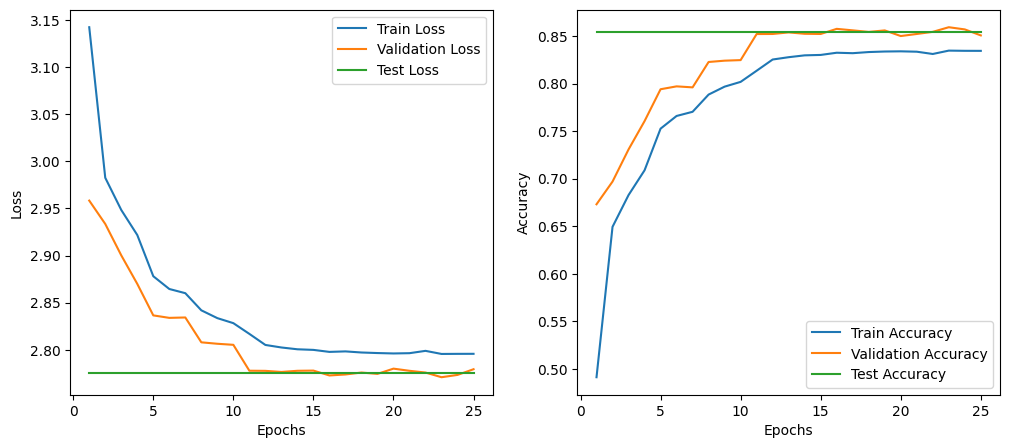

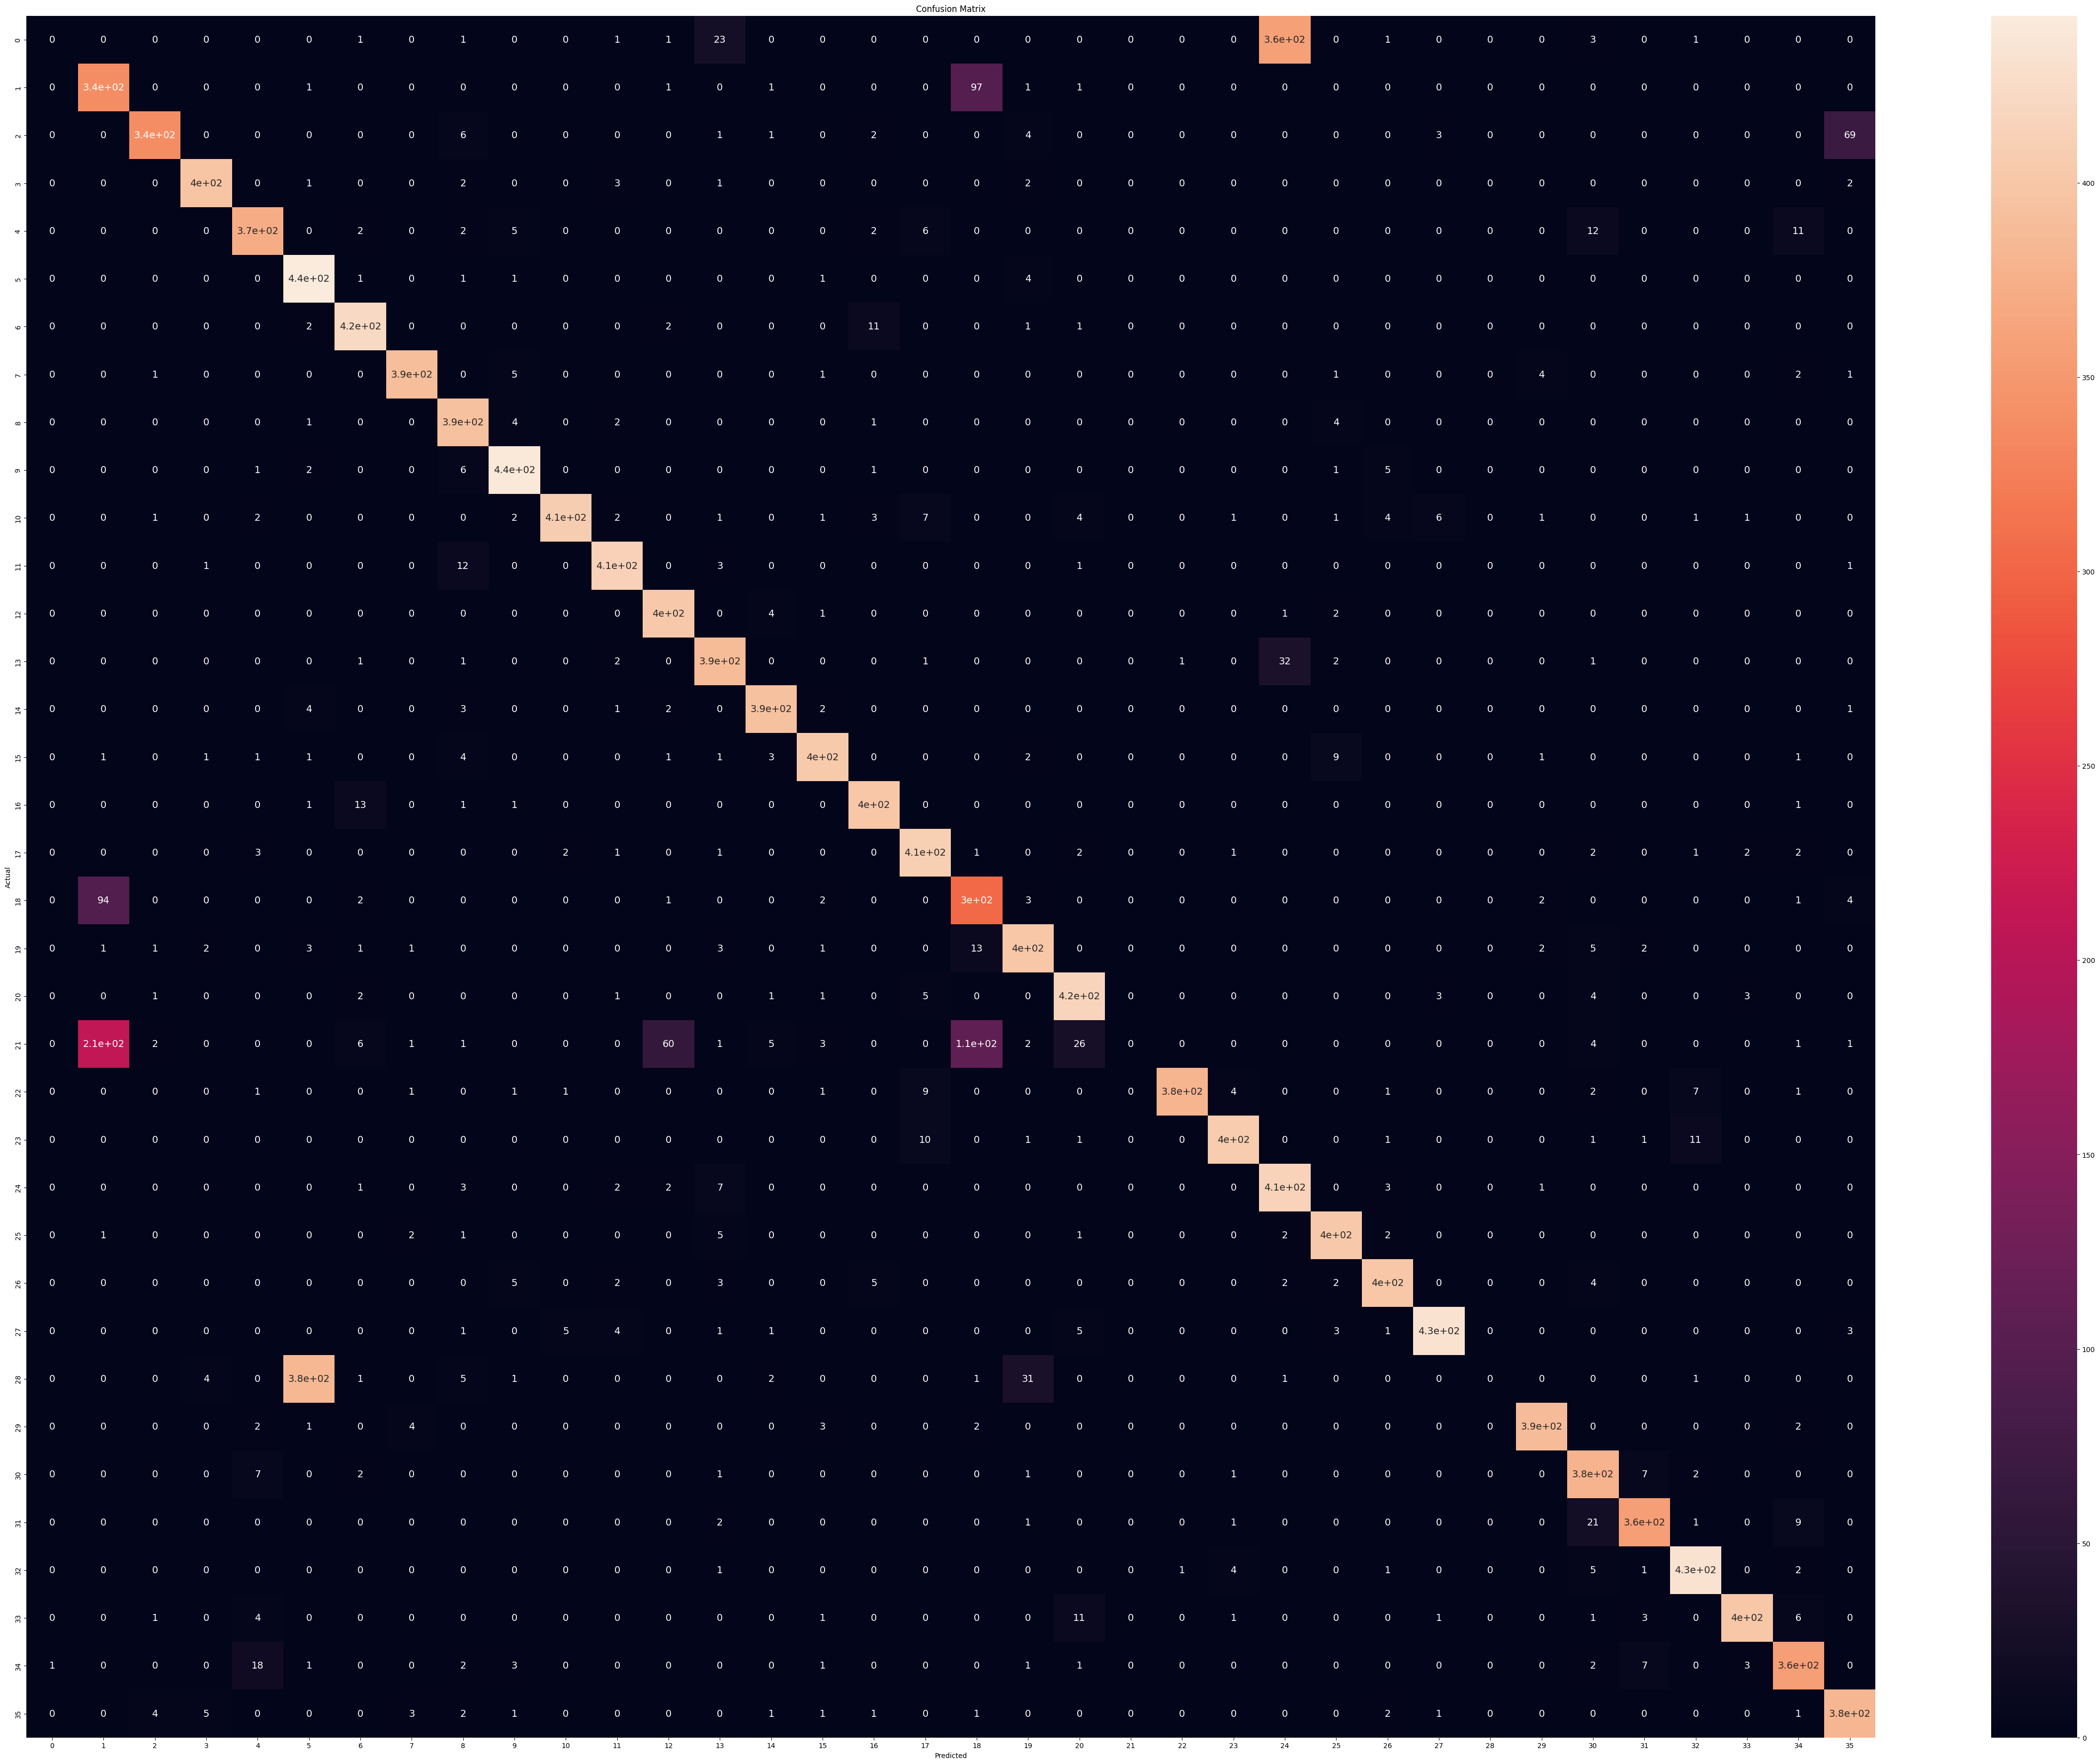

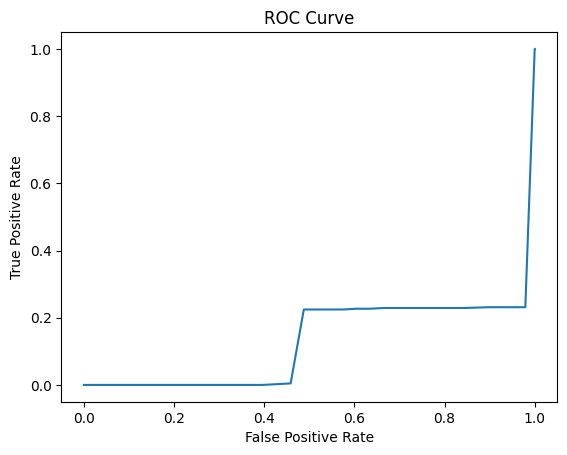

In [20]:
range_epochs = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range_epochs, train_loss_list, label='Train Loss')
plt.plot(range_epochs, val_loss_list, label='Validation Loss')
plt.plot(range_epochs, [test_loss]*epochs, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range_epochs, train_accuracy_list, label='Train Accuracy')
plt.plot(range_epochs, val_accuracy_list, label='Validation Accuracy')
plt.plot(range_epochs, [test_accuracy]*epochs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
plt.figure(figsize=(60, 45))
cm = confusion_matrix(y_actual, y_predicted)
sns.heatmap(cm, annot=True, annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(np.array(y_actual), np.array(y_predicted), pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Base Model with Normalization layer

In [5]:
class BaseCNNWithNormalization(nn.Module):
    def __init__(self):
        super(BaseCNNWithNormalization, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=64 * 7 * 7,out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=36),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
model_b1 = BaseCNNWithNormalization().to(device)
summary(model_b1, input_size=(3, 28, 28))

epochs = 25
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b1.parameters(), lr=0.001)

train_loss_list_b1, val_loss_list_b1, train_accuracy_list_b1, val_accuracy_list_b1 = [], [], [], []

start_time = time.time()
for epoch in range(epochs):
    model_b1.train()
    train_loss, correct_predictions = 0, 0
    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        if (batch_index+1)%100==0:
            print(f"Epoch: {epoch+1}/{epochs}, Batch: {batch_index+1}/{len(train_loader)}")
        optimizer.zero_grad()
        outputs = model_b1(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        train_loss += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

    train_loss_list_b1.append(train_loss / len(train_loader.dataset))
    train_accuracy_list_b1.append(correct_predictions / len(train_loader.dataset))

    model_b1.eval()
    val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_b1(inputs)
            loss = loss_function(outputs, labels)

            curr_batch_scaled_loss = loss.item() * inputs.size(0)
            val_loss += curr_batch_scaled_loss

            predicted_labels = outputs.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()

    val_loss_list_b1.append(val_loss / len(val_loader.dataset))
    val_accuracy_list_b1.append(correct_predictions / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {train_loss_list_b1[-1]:.4f}, "
          f"Validation Loss: {val_loss_list_b1[-1]:.4f}, "
          f"Training Accuracy: {train_accuracy_list_b1[-1]:.4f}, "
          f"Validation Acc: {val_accuracy_list_b1[-1]:.4f}")

    print(f"{(time.time()-start_time):.4f} seconds has passed:")
end_time = time.time()


print(f"Training took {(end_time-start_time):.4f} seconds:")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
       BatchNorm2d-7             [-1, 64, 7, 7]             128
           Flatten-8                 [-1, 3136]               0
            Linear-9                  [-1, 256]         803,072
             ReLU-10                  [-1, 256]               0
          Dropout-11                  [-1, 256]               0
           Linear-12                   [-1, 36]           9,252
          Softmax-13                   [-1, 36]               0
Total params: 831,844
Trainable params:

In [12]:
torch.save(model_b1.state_dict(), 'cnn_base_model_b1_gc.pt')

In [19]:
model_b1.eval()
test_loss_b1, correct_predictions_b1 = 0, 0
y_actual_b1, y_predicted_b1 = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_b1(inputs)
        loss = loss_function(outputs, labels)

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        test_loss_b1 += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions_b1 += (predicted_labels == labels).sum().item()

        y_actual_b1.extend(labels.cpu().numpy())
        y_predicted_b1.extend(predicted_labels.cpu().numpy())

In [20]:
test_accuracy_b1 = correct_predictions_b1 / len(test_loader.dataset)
test_loss_b1 /= len(test_loader.dataset)
precision_b1, recall_b1, f1, _ = precision_recall_fscore_support(y_actual_b1, y_predicted_b1, average="macro")

print(f"Test Loss: {test_loss_b1:.4f}, Test Accuracy: {test_accuracy_b1:.4f}")
print(f"Precision: {precision_b1:.4f}, Recall: {recall_b1:.4f}, F1 Score: {f1:.4f}")

Test Loss: 2.7420, Test Accuracy: 0.8881
Precision: 0.8783, Recall: 0.8871, F1 Score: 0.8793


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


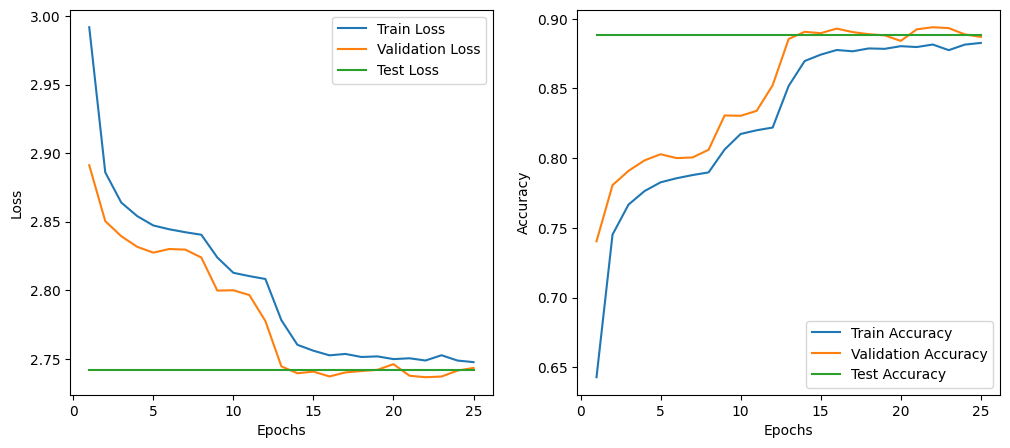

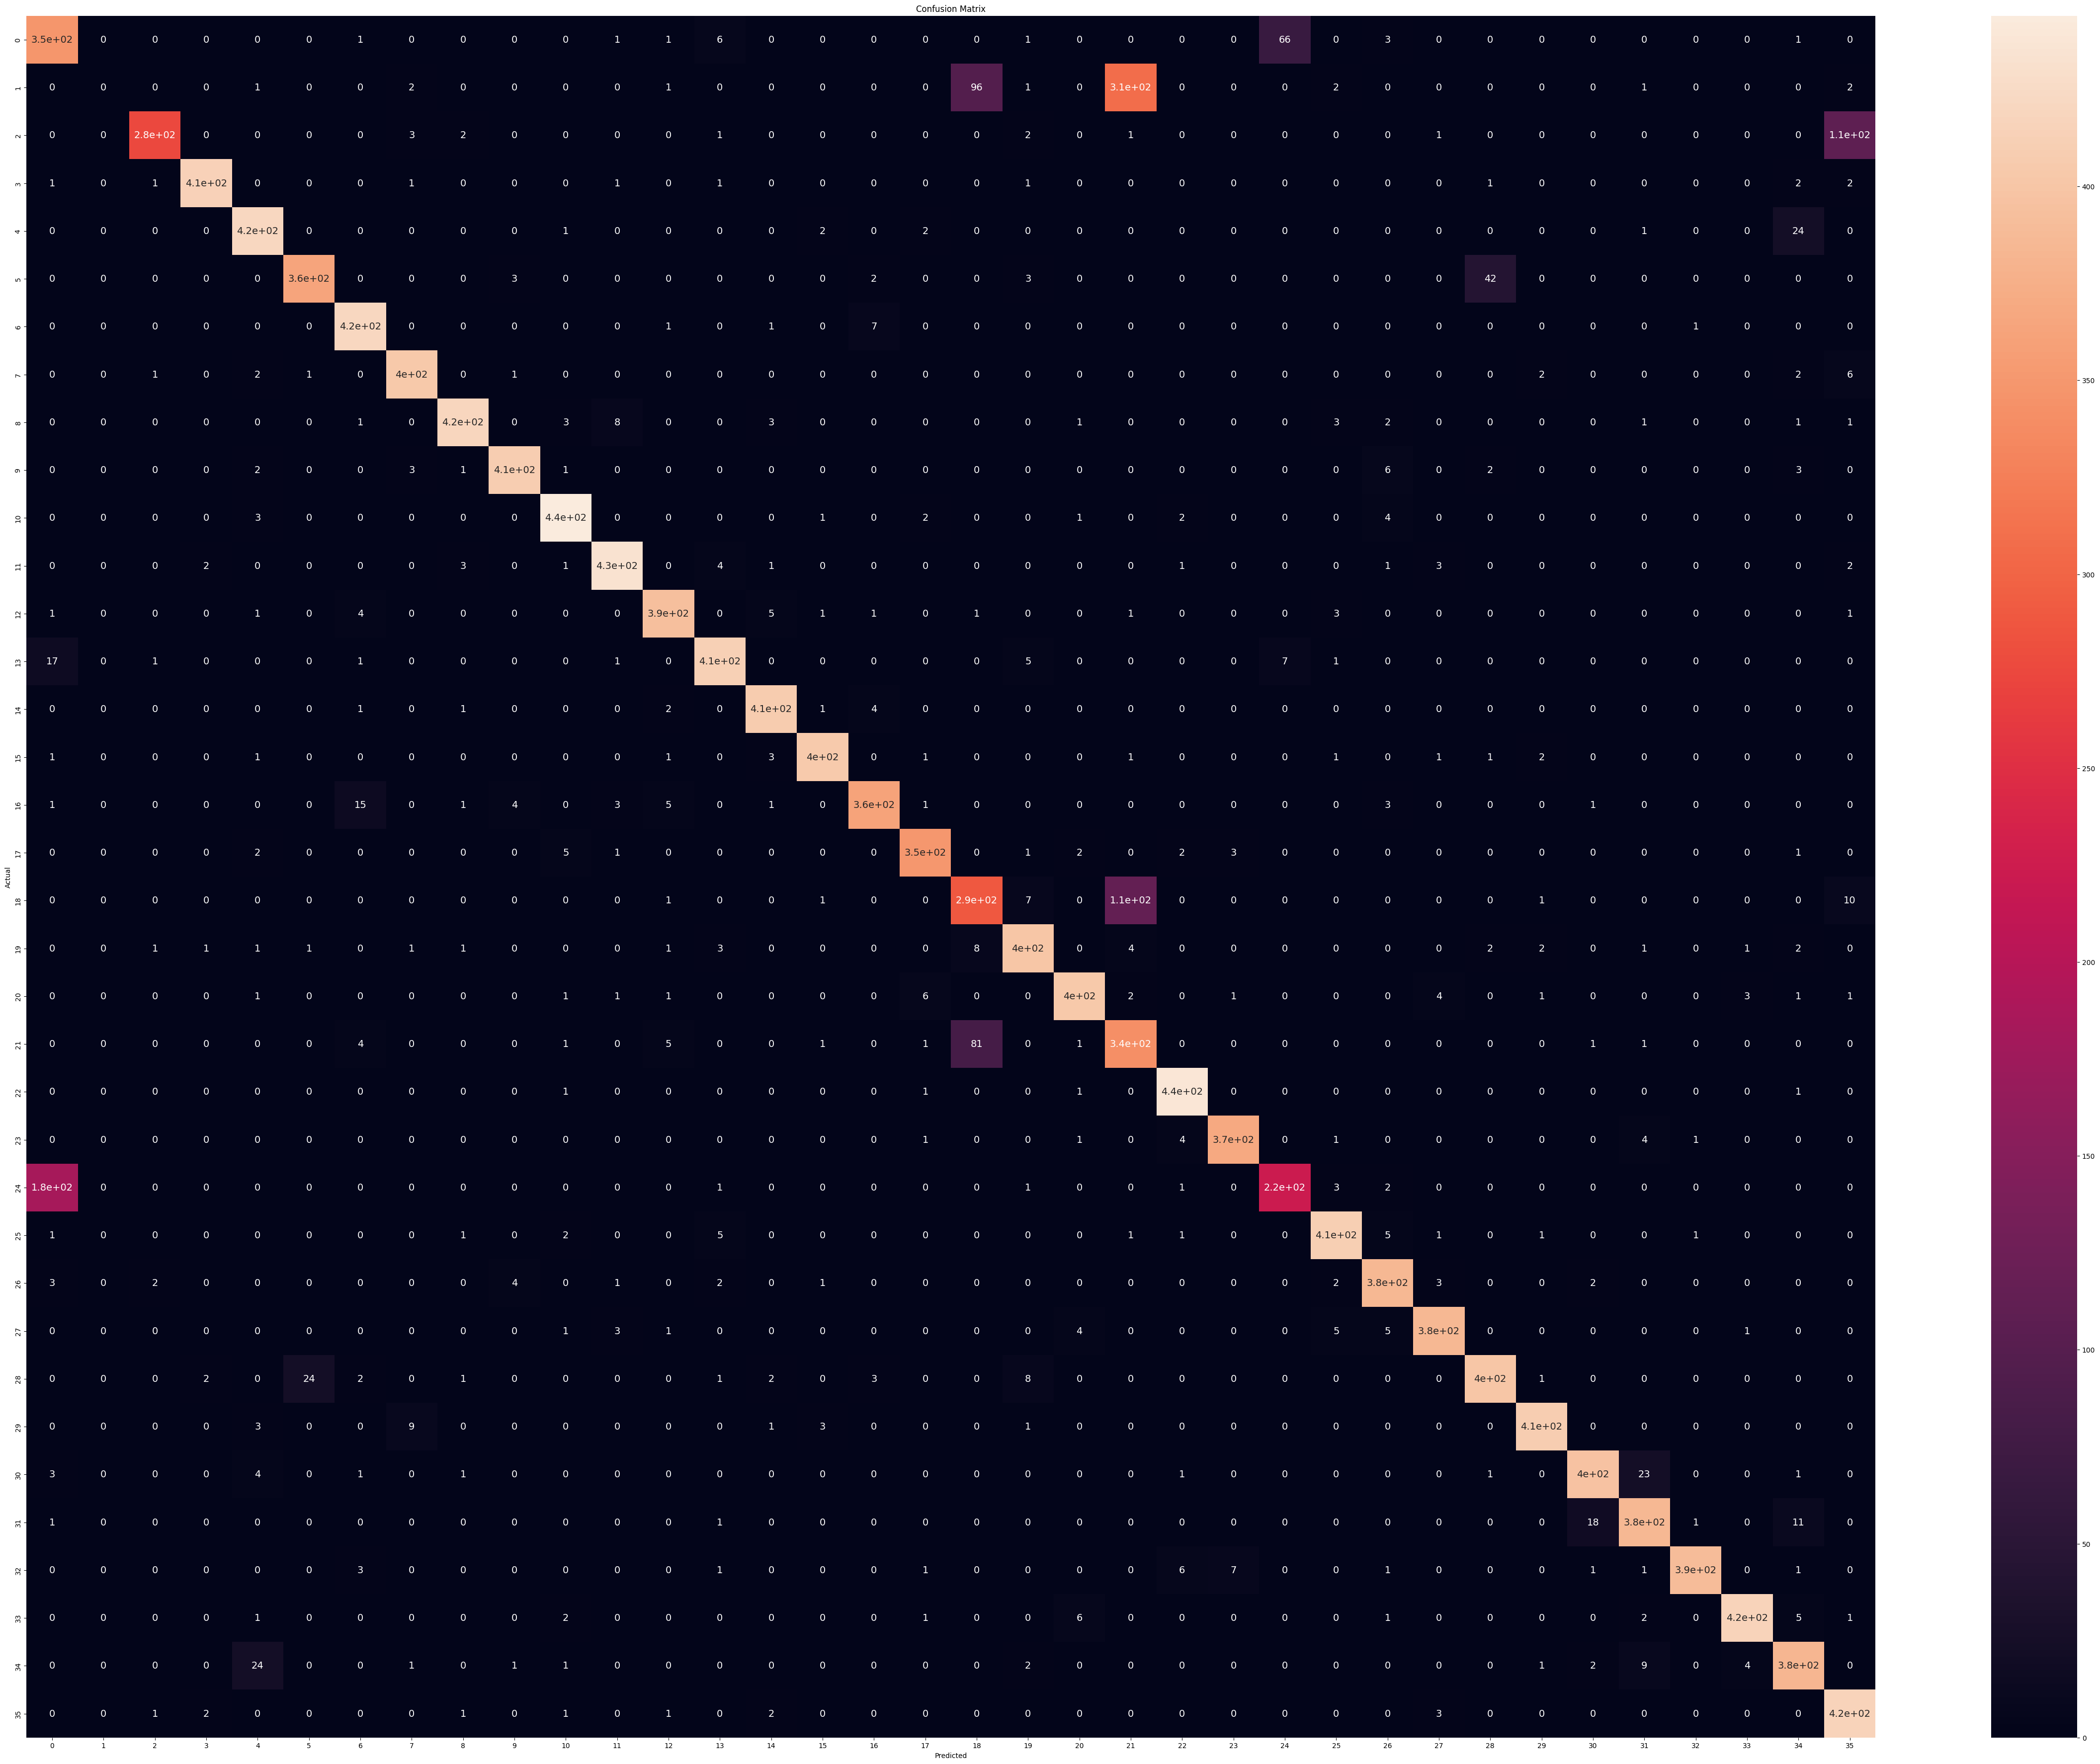

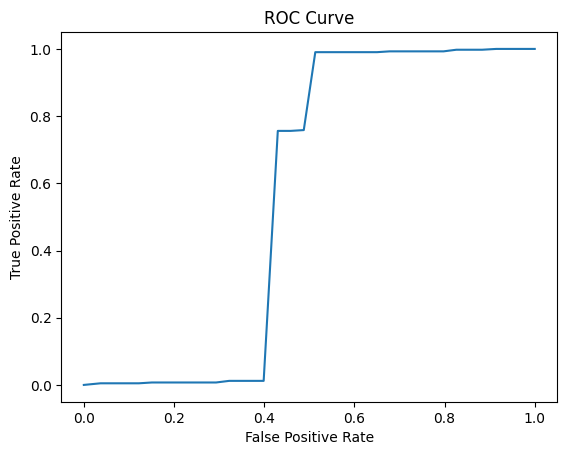

In [21]:
range_epochs = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range_epochs, train_loss_list_b1, label='Train Loss')
plt.plot(range_epochs, val_loss_list_b1, label='Validation Loss')
plt.plot(range_epochs, [test_loss_b1]*epochs, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range_epochs, train_accuracy_list_b1, label='Train Accuracy')
plt.plot(range_epochs, val_accuracy_list_b1, label='Validation Accuracy')
plt.plot(range_epochs, [test_accuracy_b1]*epochs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
plt.figure(figsize=(60, 45))
cm = confusion_matrix(y_actual_b1, y_predicted_b1)
sns.heatmap(cm, annot=True, annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(np.array(y_actual_b1), np.array(y_predicted_b1), pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Base Model with Learning Rate Scheduler

In [31]:
model_b2 = BaseCNN().to(device)
summary(model_b2, input_size=(3, 28, 28))

epochs = 25
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

train_loss_list_b2, val_loss_list_b2, train_accuracy_list_b2, val_accuracy_list_b2 = [], [], [], []

start_time = time.time()
for epoch in range(epochs):
    model_b2.train()
    train_loss, correct_predictions = 0, 0

    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        if (batch_index+1)%100==0:
            print(f"Epoch: {epoch+1}/{epochs}, Batch: {batch_index+1}/{len(train_loader)}")
        optimizer.zero_grad()
        outputs = model_b2(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        train_loss += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

    train_loss_list_b2.append(train_loss / len(train_loader.dataset))
    train_accuracy_list_b2.append(correct_predictions / len(train_loader.dataset))

    model_b2.eval()
    val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_b2(inputs)
            loss = loss_function(outputs, labels)

            curr_batch_scaled_loss = loss.item() * inputs.size(0)
            val_loss += curr_batch_scaled_loss

            predicted_labels = outputs.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()

    val_loss_list_b2.append(val_loss / len(val_loader.dataset))
    val_accuracy_list_b2.append(correct_predictions / len(val_loader.dataset))

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Learning Rate: {current_lr:.6f}, "
          f"Training Loss: {train_loss_list_b2[-1]:.4f}, "
          f"Validation Loss: {val_loss_list_b2[-1]:.4f}, "
          f"Training Accuracy: {train_accuracy_list_b2[-1]:.4f}, "
          f"Validation Acc: {val_accuracy_list_b2[-1]:.4f}")

    print(f"{(time.time()-start_time):.4f} seconds has passed:")
    scheduler.step()
end_time = time.time()


print(f"Training took {(end_time-start_time):.4f} seconds:")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
              ReLU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 36]           9,252
          Softmax-12                   [-1, 36]               0
Total params: 831,716
Trainable params: 831,716
Non-trainable params: 0
-------------------------------

In [32]:
torch.save(model_b2.state_dict(), 'cnn_base_model_b2_gc.pt')

In [33]:
model_b2.eval()
test_loss_b2, correct_predictions_b2 = 0, 0
y_actual_b2, y_predicted_b2 = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_b2(inputs)
        loss = loss_function(outputs, labels)

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        test_loss_b2 += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions_b2 += (predicted_labels == labels).sum().item()

        y_actual_b2.extend(labels.cpu().numpy())
        y_predicted_b2.extend(predicted_labels.cpu().numpy())

In [34]:
test_accuracy_b2 = correct_predictions_b2 / len(test_loader.dataset)
test_loss_b2 /= len(test_loader.dataset)
precision_b2, recall_b2, f1, _ = precision_recall_fscore_support(y_actual_b2, y_predicted_b2, average="macro")

print(f"Test Loss: {test_loss_b2:.4f}, Test Accuracy: {test_accuracy_b2:.4f}")
print(f"Precision: {precision_b2:.4f}, Recall: {recall_b2:.4f}, F1 Score: {f1:.4f}")

Test Loss: 2.7494, Test Accuracy: 0.8806
Precision: 0.8641, Recall: 0.8793, F1 Score: 0.8669


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


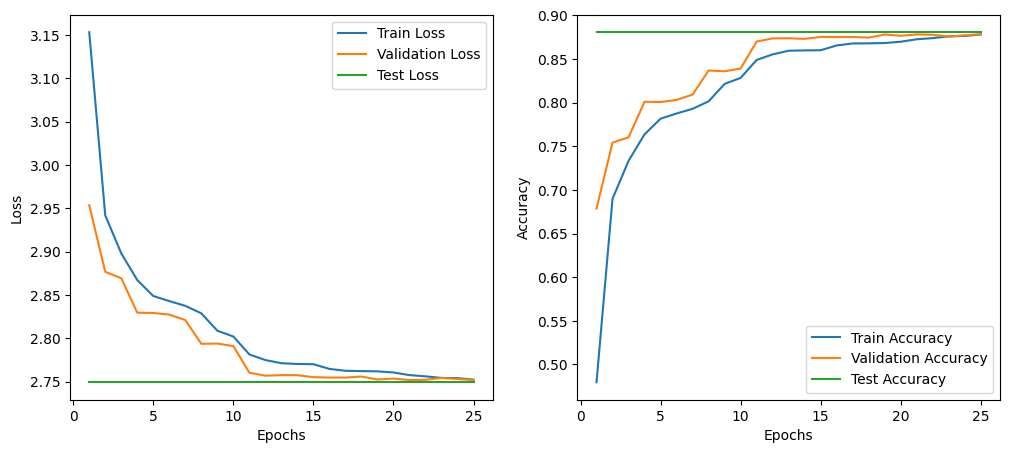

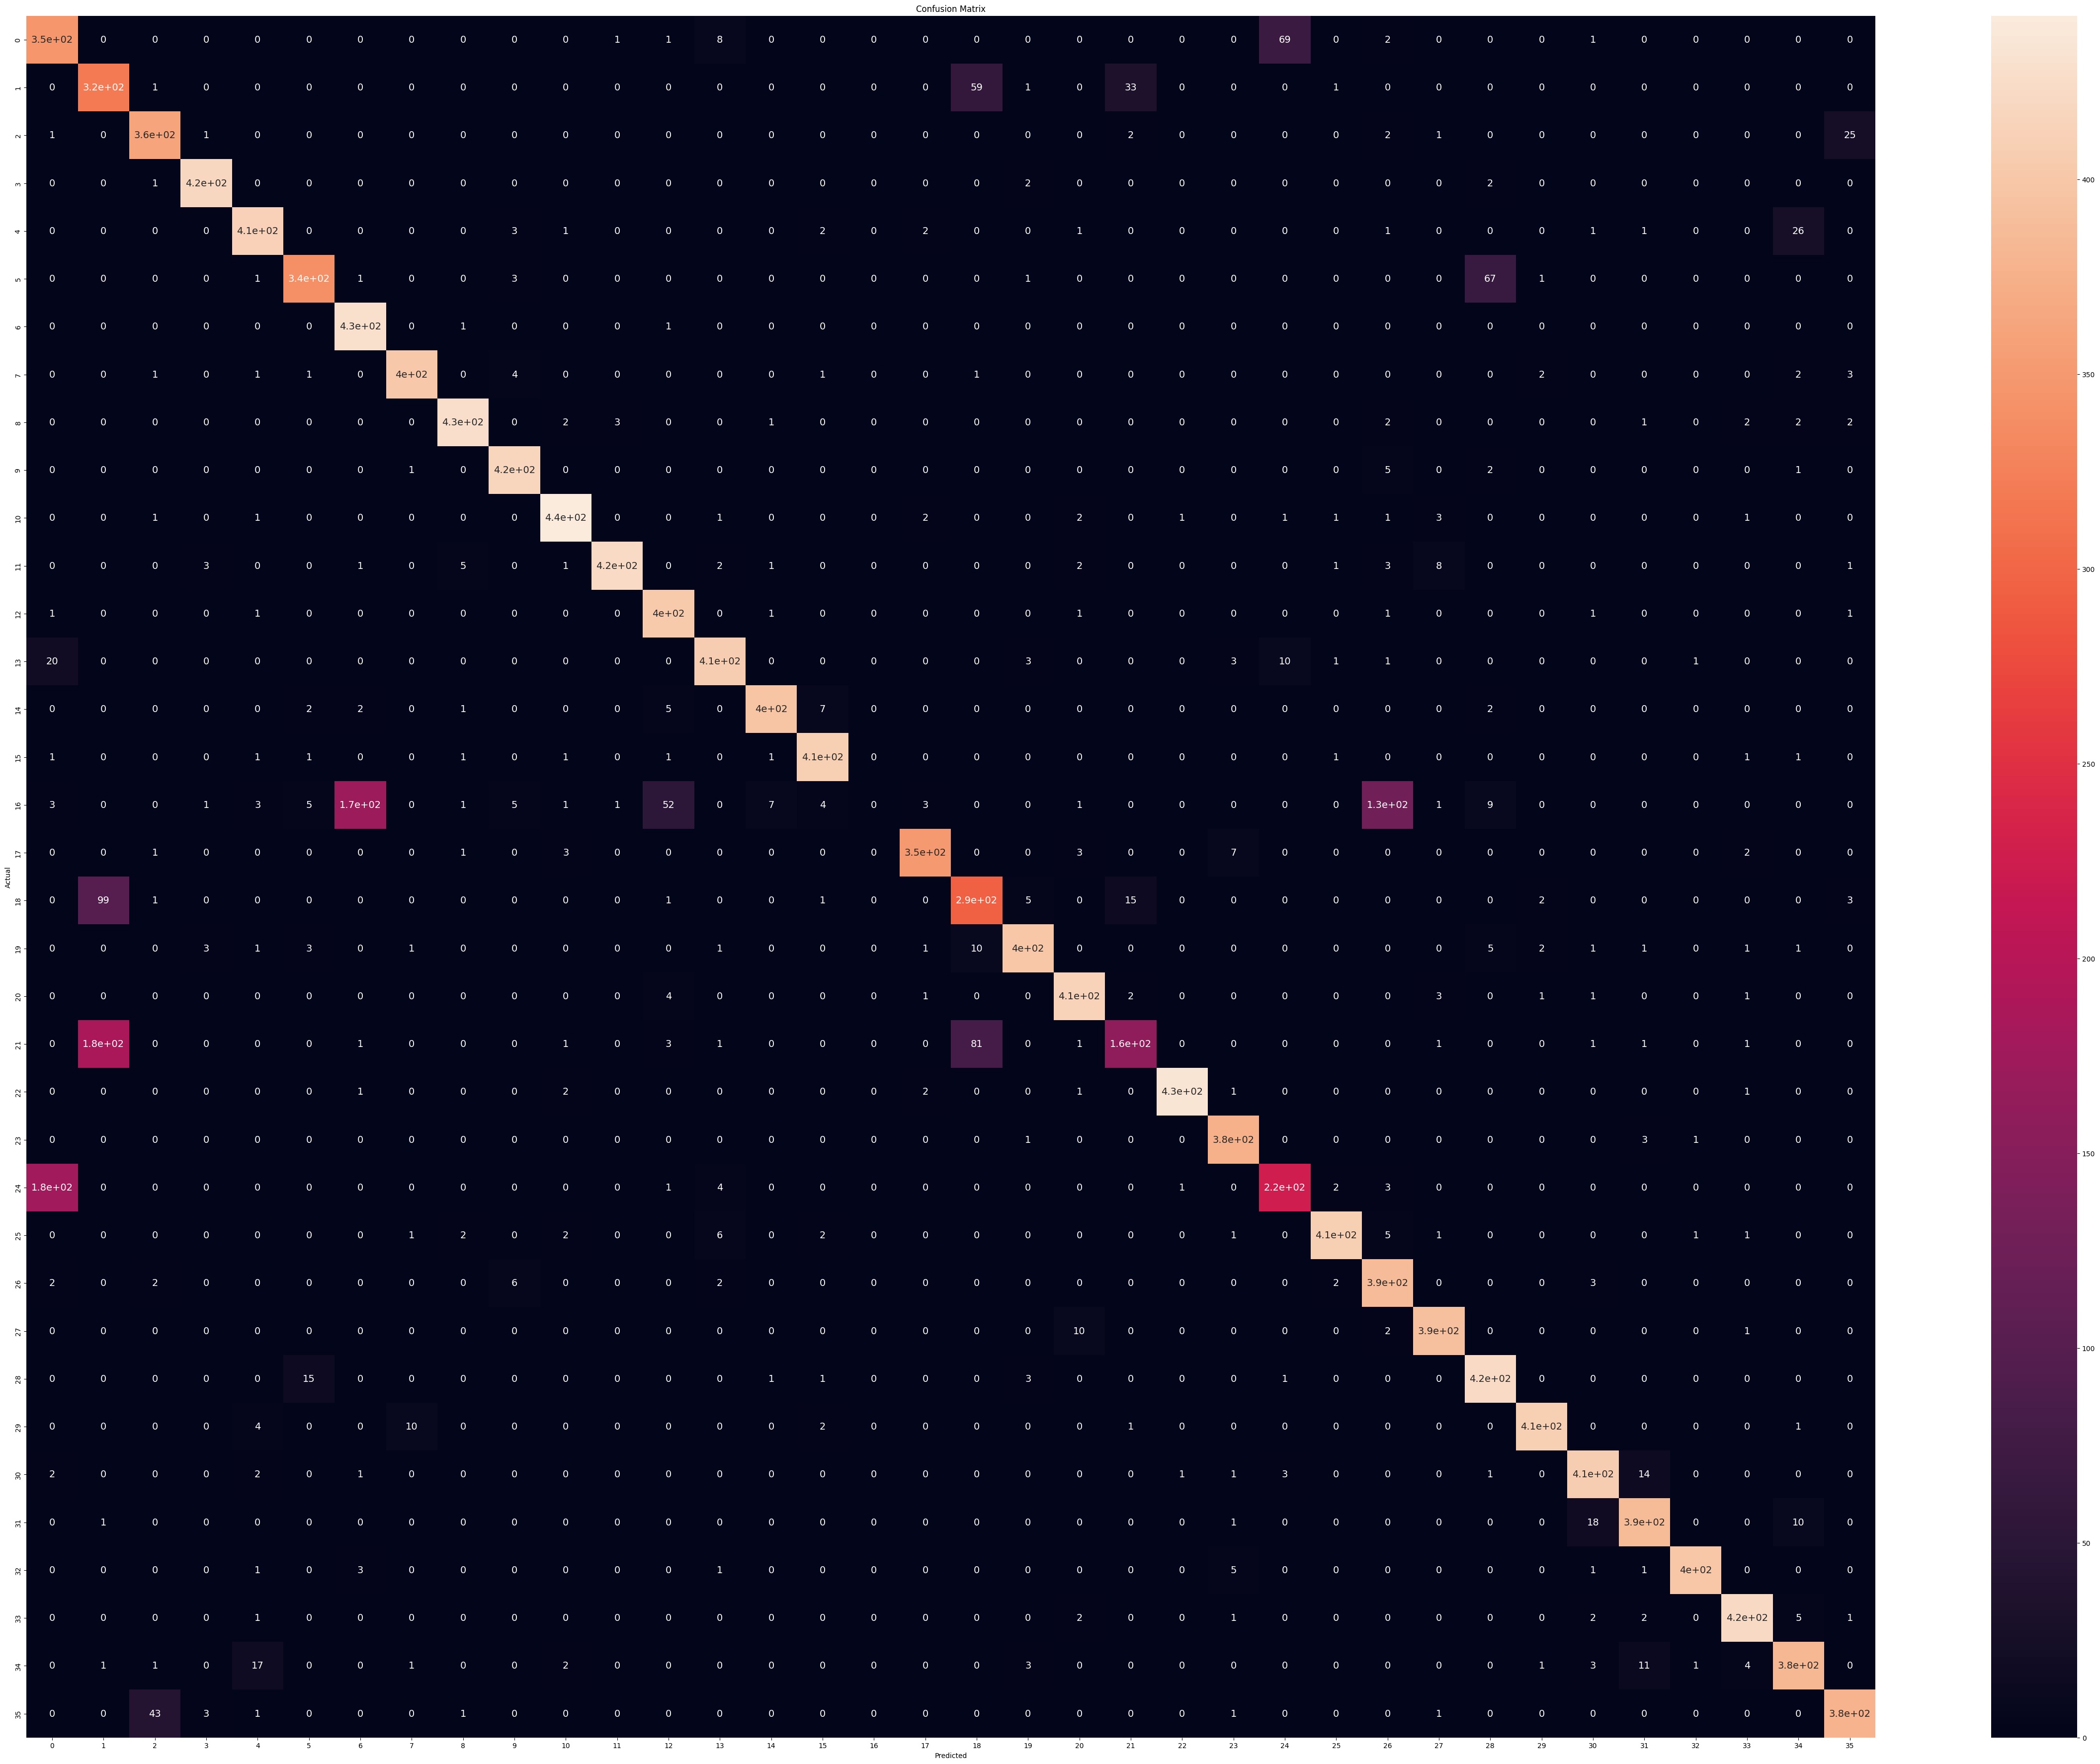

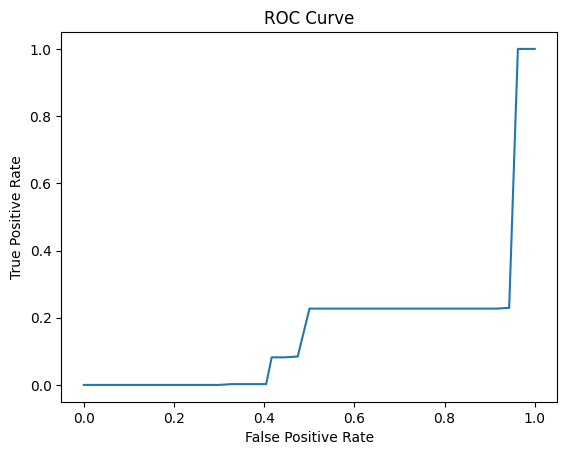

In [35]:
range_epochs = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range_epochs, train_loss_list_b2, label='Train Loss')
plt.plot(range_epochs, val_loss_list_b2, label='Validation Loss')
plt.plot(range_epochs, [test_loss_b2]*epochs, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range_epochs, train_accuracy_list_b2, label='Train Accuracy')
plt.plot(range_epochs, val_accuracy_list_b2, label='Validation Accuracy')
plt.plot(range_epochs, [test_accuracy_b2]*epochs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
plt.figure(figsize=(60, 45))
cm = confusion_matrix(y_actual_b2, y_predicted_b2)
sns.heatmap(cm, annot=True, annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(np.array(y_actual_b2), np.array(y_predicted_b2), pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Base Model with batch size = 128

In [18]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root='./dataset', transform=transform)

train_dataset_fraction = 0.7
val_dataset_fraction = 0.15

train_size = int(train_dataset_fraction * len(dataset))
val_size = int(val_dataset_fraction * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Training Dataset size: {train_size}, Validation Dataset Size: {val_size}, Test Dataset Size: {test_size}")

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=128)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

Training Dataset size: 70560, Validation Dataset Size: 15120, Test Dataset Size: 15120


In [11]:
model_b3 = BaseCNN().to(device)
summary(model_b3, input_size=(3, 28, 28))

epochs = 25
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b3.parameters(), lr=0.001)

train_loss_list_b3, val_loss_list_b3, train_accuracy_list_b3, val_accuracy_list_b3 = [], [], [], []

start_time = time.time()
for epoch in range(epochs):
    model_b3.train()
    train_loss, correct_predictions = 0, 0
    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        if (batch_index+1)%100==0:
            print(f"Epoch: {epoch+1}/{epochs}, Batch: {batch_index+1}/{len(train_loader)}")
        optimizer.zero_grad()
        outputs = model_b3(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        train_loss += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

    train_loss_list_b3.append(train_loss / len(train_loader.dataset))
    train_accuracy_list_b3.append(correct_predictions / len(train_loader.dataset))

    model_b3.eval()
    val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_b3(inputs)
            loss = loss_function(outputs, labels)

            curr_batch_scaled_loss = loss.item() * inputs.size(0)
            val_loss += curr_batch_scaled_loss

            predicted_labels = outputs.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()

    val_loss_list_b3.append(val_loss / len(val_loader.dataset))
    val_accuracy_list_b3.append(correct_predictions / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {train_loss_list_b3[-1]:.4f}, "
          f"Validation Loss: {val_loss_list_b3[-1]:.4f}, "
          f"Training Accuracy: {train_accuracy_list_b3[-1]:.4f}, "
          f"Validation Acc: {val_accuracy_list_b3[-1]:.4f}")

    print(f"{(time.time()-start_time):.4f} seconds has passed:")
end_time = time.time()


print(f"Training took {(end_time-start_time):.4f} seconds:")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
              ReLU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 36]           9,252
          Softmax-12                   [-1, 36]               0
Total params: 831,716
Trainable params: 831,716
Non-trainable params: 0
-------------------------------

In [13]:
torch.save(model_b3.state_dict(), 'cnn_base_model_b3_gc.pt')

In [14]:
model_b3.eval()
test_loss_b3, correct_predictions_b3 = 0, 0
y_actual_b3, y_predicted_b3 = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_b3(inputs)
        loss = loss_function(outputs, labels)

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        test_loss_b3 += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions_b3 += (predicted_labels == labels).sum().item()

        y_actual_b3.extend(labels.cpu().numpy())
        y_predicted_b3.extend(predicted_labels.cpu().numpy())

In [15]:
test_accuracy_b3 = correct_predictions_b3 / len(test_loader.dataset)
test_loss_b3 /= len(test_loader.dataset)
precision_b3, recall_b3, f1, _ = precision_recall_fscore_support(y_actual_b3, y_predicted_b3, average="macro")

print(f"Test Loss: {test_loss_b3:.4f}, Test Accuracy: {test_accuracy_b3:.4f}")
print(f"Precision: {precision_b3:.4f}, Recall: {recall_b3:.4f}, F1 Score: {f1:.4f}")

Test Loss: 2.7629, Test Accuracy: 0.8668
Precision: 0.8469, Recall: 0.8686, F1 Score: 0.8463


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


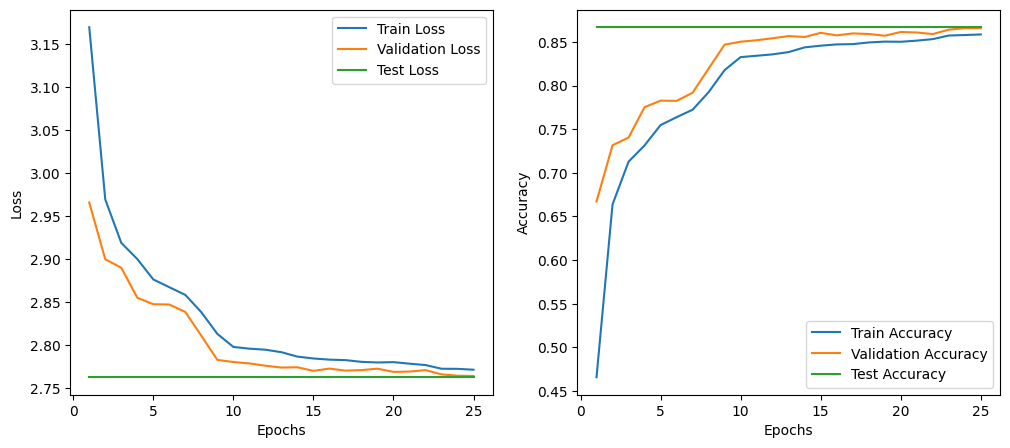

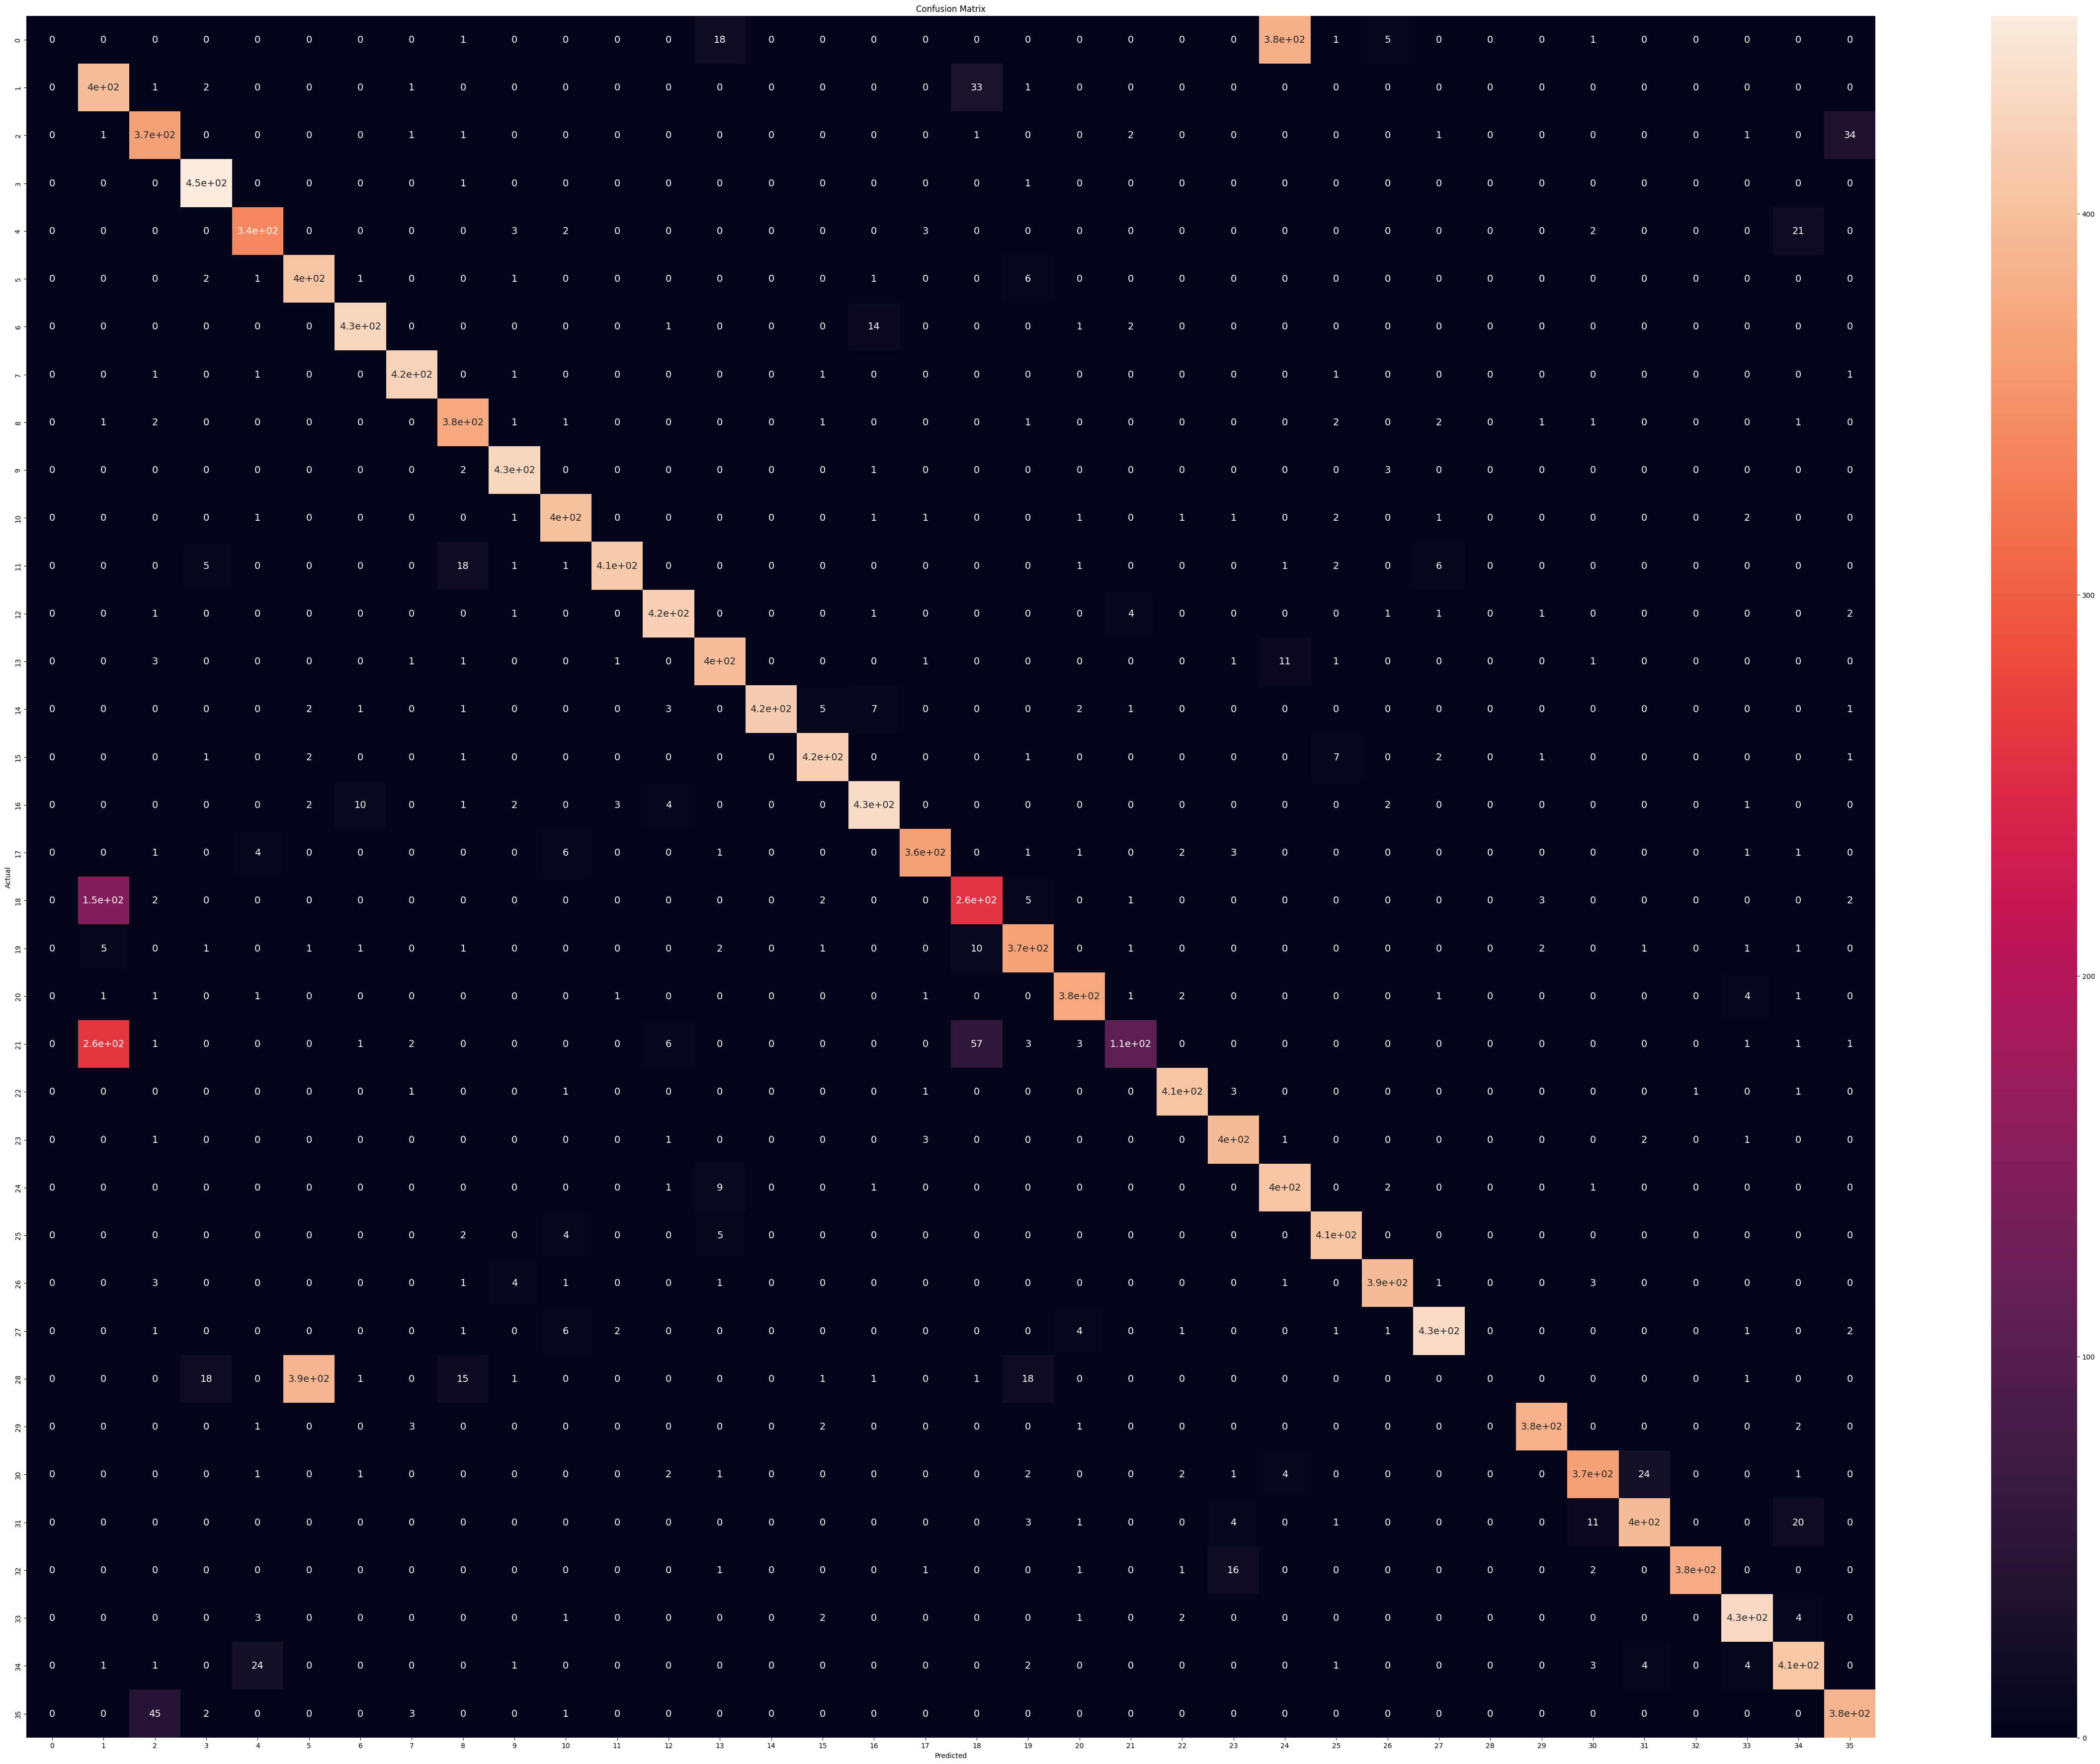

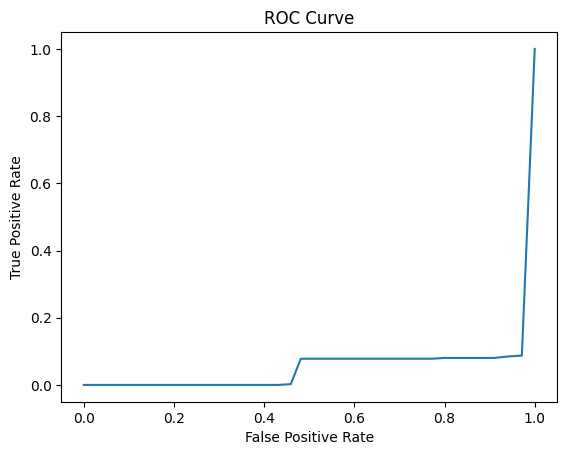

In [16]:
range_epochs = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range_epochs, train_loss_list_b3, label='Train Loss')
plt.plot(range_epochs, val_loss_list_b3, label='Validation Loss')
plt.plot(range_epochs, [test_loss_b3]*epochs, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range_epochs, train_accuracy_list_b3, label='Train Accuracy')
plt.plot(range_epochs, val_accuracy_list_b3, label='Validation Accuracy')
plt.plot(range_epochs, [test_accuracy_b3]*epochs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
plt.figure(figsize=(60, 45))
cm = confusion_matrix(y_actual_b3, y_predicted_b3)
sns.heatmap(cm, annot=True, annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(np.array(y_actual_b3), np.array(y_predicted_b3), pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()